# Analyzing NYC High School Data

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it. This project focuses on investigating the correlations between SAT scores and demographics of NYC high schools. We could correlate SAT scores with factors like race, gender, income, and more.

We have multiple datasets to investigate for analysing the correlations between SAT scores and demographics.

Here are the links to all of the data sets we'll be using:

- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

Few different things to learn the [link](https://data.cityofnewyork.us/browse?category=Education) to get better understanding of our data. For example:

- Only high school students take the SAT, so we'll want to focus on high schools.
- New York City is made up of five boroughs, which are essentially distinct regions.
- New York City schools fall within several different school districts, each of which can contains dozens of schools.
- Our data sets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
- Each school in New York City has a unique code called a DBN, or district borough number.
- Aggregating data by district will allow us to use the district mapping data to plot district-by-district differences.

All the data files are placed in the schools folder. Here are all of the files in the folder:

- ap_2010.csv - Data on AP test results
- class_size.csv - Data on class size
- demographics.csv - Data on demographics
- graduation.csv - Data on graduation outcomes
- hs_directory.csv - A directory of high schools
- sat_results.csv - Data on SAT scores
- survey_all.txt - Data on surveys from all schools
- survey_d75.txt - Data on surveys from New York City district 75



## Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

for key in data:
    print(data[key].head(5))

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

**REMARKS:**
- The DBN appears to be a unique ID for each school.
- We can tell from the first few rows of names that we only have data about high schools.
- There's only a single row for each high school, so each DBN is unique in the SAT data.
- We may eventually want to combine the three columns that contain SAT scores -- SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score -- into a single column to make the scores easier to analyze.
- Some of the data sets appear to contain multiple rows for each school (because the rows have duplicate DBN values). That means we’ll have to do some preprocessing to ensure that each DBN is unique within each data set. If we don't do this, we'll run into problems when we combine the data sets, because we might be merging two rows in one data set with one row in another data set.

## Reading the text files of surveys

Each Survey text files is
- tab delimited and encoded with Windows-1252 encoding. 
- An encoding defines how a computer stores the contents of a file in binary. The most common encodings are UTF-8 and ASCII. Windows-1252 is rarely used, and can cause errors if we read such a file in without specifying the encoding. If you'd like to read more about encodings, here's a good primer.


In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
### if the DataFrames have different columns, or the same columns in a different order, pandas returns a warning if no parameter sort is explicitly set (sort=None is the default value):
### if sort=True, columns are sorted alphanumerically and the warning generated can be eliminated
survey = pd.concat([all_survey, d75_survey], axis=0,sort=True)

print(survey.head())



     N_p    N_s   N_t  aca_p_11  aca_s_11  aca_t_11  aca_tot_11    bn  \
0   90.0    NaN  22.0       7.8       NaN       7.9         7.9  M015   
1  161.0    NaN  34.0       7.8       NaN       9.1         8.4  M019   
2  367.0    NaN  42.0       8.6       NaN       7.5         8.0  M020   
3  151.0  145.0  29.0       8.5       7.4       7.8         7.9  M034   
4   90.0    NaN  23.0       7.9       NaN       8.1         8.0  M063   

   com_p_11  com_s_11  ...  t_q8c_1  t_q8c_2  t_q8c_3 t_q8c_4  t_q9  t_q9_1  \
0       7.6       NaN  ...     29.0     67.0      5.0     0.0   NaN     5.0   
1       7.6       NaN  ...     74.0     21.0      6.0     0.0   NaN     3.0   
2       8.3       NaN  ...     33.0     35.0     20.0    13.0   NaN     3.0   
3       8.2       5.9  ...     21.0     45.0     28.0     7.0   NaN     0.0   
4       7.9       NaN  ...     59.0     36.0      5.0     0.0   NaN    10.0   

   t_q9_2  t_q9_3  t_q9_4  t_q9_5  
0    14.0    52.0    24.0     5.0  
1     6.0     

**REMARK**
- There are over 2000 columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns will make it easier to print the dataframe out
- The survey data has a dbn column that we'll want to convert to uppercase (DBN).

Using [data dictionay](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) for survey files, we can filter required columns for our correlation analysis.

The columns in surevy_fields will give us aggregate survey data about how parents, teachers, and students feel about school safety, academic performance, and more. It will also give us the DBN, which allows us to uniquely identify the school.

In [3]:
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]

# adding survey to our data dictionary
data["survey"] = survey

In [4]:
print(data["class_size"].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


## Add DBN columns
When we explored all of the data sets, we noticed that some of them, like class_size and hs_directory, don't have a DBN column. hs_directory does have a dbn column, though, so we can just rename it.
- DBN in the sat_results data is just a combination of the CSD and SCHOOL CODE columns in the class_size data. 
- The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits. That means we'll need to add a leading 0 to the CSD if the CSD is less than two digits long.

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    to_string = str(num)
    if len(to_string) > 1:
        return to_string
    else:
        return "0" + to_string

# def pad_csd(num):
#    return str(num).zfill(2)
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

- use pandas.to_numeric() method to convert string to numeric with keyword argument errors="coerce" (this treats any invalid string which can't be converted to numeric as missing value)

In [6]:
print(data["sat_results"].head())

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

In [7]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")


## Condense datasets

- We're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the GRADE column is 09-12.

- Each school can have multiple program types. Because GEN ED is the largest category by far, let's only select rows where PROGRAM TYPE is GEN ED.



In [8]:
print(data["class_size"].columns)

Index(['CSD', 'BOROUGH', 'SCHOOL CODE', 'SCHOOL NAME', 'GRADE ',
       'PROGRAM TYPE', 'CORE SUBJECT (MS CORE and 9-12 ONLY)',
       'CORE COURSE (MS CORE and 9-12 ONLY)', 'SERVICE CATEGORY(K-9* ONLY)',
       'NUMBER OF STUDENTS / SEATS FILLED', 'NUMBER OF SECTIONS',
       'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS',
       'DATA SOURCE', 'SCHOOLWIDE PUPIL-TEACHER RATIO', 'padded_csd', 'DBN'],
      dtype='object')


In [9]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

print(class_size["DBN"].value_counts())

20K505    21
09X505    21
25Q425    20
30Q445    20
21K525    20
22K495    20
24Q485    20
26Q435    20
20K490    20
21K540    20
27Q410    19
26Q415    19
01M539    19
21K690    19
11X545    19
28Q470    19
02M655    19
08X405    19
22K405    19
19K409    19
26Q430    19
13K670    19
26Q495    19
25Q285    19
30Q450    19
06M540    19
10X440    19
31R460    19
10X696    19
21K410    19
          ..
03M334     1
27Q183     1
15K443     1
16K308     1
06M324     1
27Q282     1
17K394     1
08X301     1
03M247     1
11X083     1
06M328     1
09X325     1
12X211     1
04M050     1
10X390     1
30Q122     1
20K030     1
30Q126     1
09X303     1
31R063     1
10X254     1
10X391     1
07X298     1
32K377     1
03M402     1
29Q059     1
08X125     1
01M378     1
10X080     1
24Q077     1
Name: DBN, Length: 583, dtype: int64


**REMARK**
- In **class_size dataset**, DBN still isn't completely unique. This is due to the CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) columns.
    - CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) seem to pertain to different kinds of classes such as('ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES').
-  We want our class size data to include every single class a school offers -- not just a subset of them. What we can do is take the average across all of the classes a school offers.

*NOTE:* The column on which grouping was performed becomes index.To undo this we use pandas.DataFrame.reset_index()

- For **demographics dataset**,  the only column that prevents a given DBN from being unique is schoolyear. We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data.

- The Demographic and Cohort columns are what prevent DBN from being unique in the **graduation data**. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [10]:
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

The only remaining thing to do is convert the Advanced Placement (AP) test scores from strings to numeric values. High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit. AP exams have a 1 to 5 scale; 3 or higher is a passing score.

- Many high school students take AP exams -- particularly those who attend academically challenging institutions. 
    - It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools.
    - In the ap_2010 dataset,  'AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5' cloumns need to be converted to numeric.

In [11]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

There may be DBN values that exist in one data set but not in another. This is partly because the data is from different years. Each data set also has inconsistencies in terms of how it was gathered.Therefore, we may not find matches for the DBN values in sat_results in all of the other data sets, and other data sets may have DBN values that don't exist in sat_results.
- So, we'll merge two data sets at a time.
- We should pick right merge strategy to minimize missing values.
    - Because this project is concerned with determing demographic factors that correlate with SAT score, we'll want to preserve as many rows as possible from sat_results while minimizing null values. 
    - This means that we may need to use different merge strategies with different data sets. 
    - class_size, demographics, survey, and hs_directory files contain information that's more valuable to our analysis and also have fewer missing DBN values, we'll use the inner join type.
    
*NOTE* There will be some rows with NaN as we used left join. So, we will replace those missing values with mean of the column using df.fillna() method and any msiing values after replacement is filled with 0.

In [12]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this.

- The school district is just the first two characters of the DBN. We can apply a function over the DBN column of combined that pulls out the first two letters.

In [13]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [14]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

**REMARK**

We can also make some other observations:

- total_enrollment has a strong positive correlation with sat_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
- Other columns that are proxies for enrollment correlate similarly. These include total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS.
- Both the percentage of females (female_per) and number of females (female_num) at a school correlate positively with SAT score, whereas the percentage of males (male_per) and the number of males (male_num) correlate negatively. This could indicate that women do better on the SAT than men.
- Teacher and student ratings of school safety (saf_t_11, and saf_s_11) correlate with sat_score.
- Student ratings of school academic standards (aca_s_11) correlate with sat_score, but this does not hold for ratings from teachers and parents (aca_p_11 and aca_t_11).
- There is significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
- The percentage of English language learners at the school (ell_percent, frl_percent) has a strong negative correlation with SAT scores.

## Plotting survey correlations

In [15]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

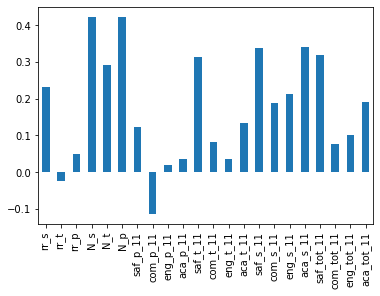

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

combined.corr()["sat_score"][survey_fields].plot.bar()

**REAMRK**

8 columns have positive correlation above 0.25. 

- There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

- It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

- How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

- The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

## Exploring safety

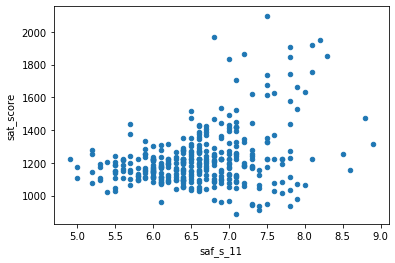

In [17]:
combined.plot.scatter("saf_s_11","sat_score")


There appears to be a correlation between SAT scores and safety, although it isn't thatstrong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

## Borough safety

In [18]:
safety=combined.groupby("boro").agg(numpy.mean)["saf_s_11"]
print(safety)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.

## Racial differences in SAT scores

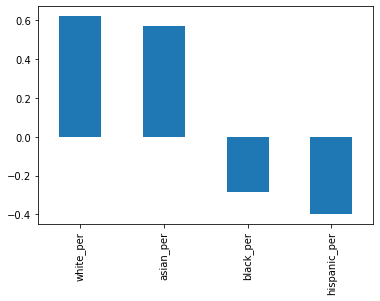

In [19]:
combined.corr()["sat_score"][["white_per","asian_per","black_per","hispanic_per"]].plot.bar()

sat_score is high positive correlation for white and asian group.Since, corelation across blacks is less than -0.25, we can conclude that there is significant correlation. However, hispanic group is significant correlated with r value over -0.25. Let's investigate further in hispanic community to get clear picture as to why SAT scores are low.

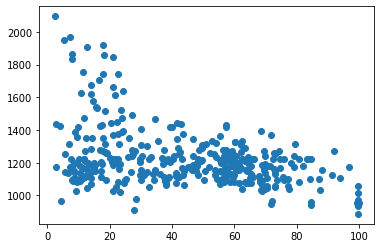

In [20]:
plt.scatter(combined['hispanic_per'], combined['sat_score'])
plt.show() 

In [21]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [22]:
print(combined[((combined["hispanic_per"] < 10) & (combined["sat_score"]>1800))]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object



Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

## Gender differences in SAT scores

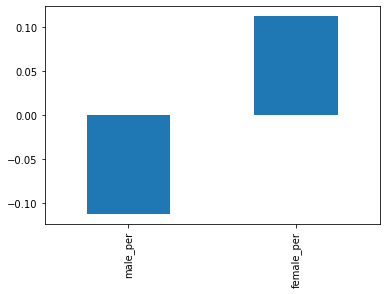

In [23]:
combined.corr()["sat_score"][["male_per","female_per"]].plot.bar()

Female students are positively correlated while opposite is true for male students. Female students tend to score more than male students. 

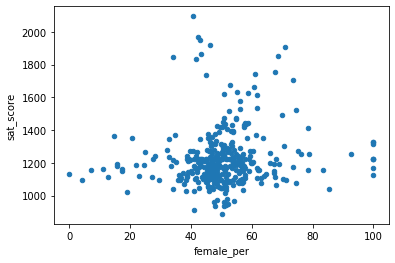

In [24]:
combined.plot.scatter("female_per","sat_score")

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [25]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"]>1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object



These schools appears to be very selective liberal arts schools that have high academic standards.

## AP Exam Scores vs SAT Scores

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

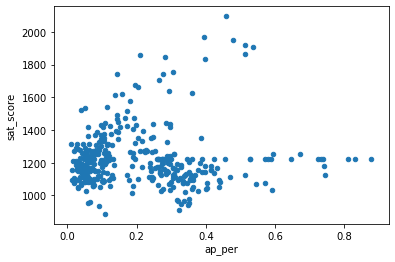

In [26]:
combined["ap_per"]=combined["AP Test Takers "]/combined["total_enrollment"]

combined.plot.scatter("ap_per","sat_score")

# Conclusion

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.